In [1]:
%load_ext autoreload
%autoreload 2
import torch
import numpy as np
import my_scripts
import matplotlib.pyplot as plt
import sklearn
import pandas as pd
import seaborn as sns
import autoencoder
from sklearn.metrics import silhouette_score
from Bio import SeqIO
from Bio.SeqRecord import SeqRecord
from Bio.Seq import Seq
import tqdm
from scipy.stats import pearsonr
from scipy.spatial.distance import cdist

In [2]:
# Load Autoencoder model

SEED = 10
MSA_length = 202
AA_latent = 50
latent_dim = 100

AE_v1 = autoencoder.Autoencoder_v1(taille=MSA_length, AA_latent=AA_latent, latent_dim=latent_dim, dropout_rate=0.3)
AE_v1.load_state_dict(torch.load('modele/ae_v1.pth'))

# Load data

AE_v1.eval()
X, Y, labels = my_scripts.generation_dataset(18000, SEED)
Xlatent = AE_v1.encoder(torch.Tensor(X)).detach().numpy()

In [3]:
# Fit Gaussian Mixture Model

gmm = sklearn.mixture.GaussianMixture(n_components=20, random_state=SEED)
gmm_affectations = gmm.fit_predict(Xlatent)
gmm_compositions = my_scripts.composition_clusters(labels, gmm_affectations, Y)

# Save GMM parameters

np.save("GM/means", gmm.means_)
np.save("GM/weights", gmm.weights_)
np.save("GM/covariances", gmm.covariances_)
np.save("GM/precisions_cholesky", gmm.precisions_cholesky_)

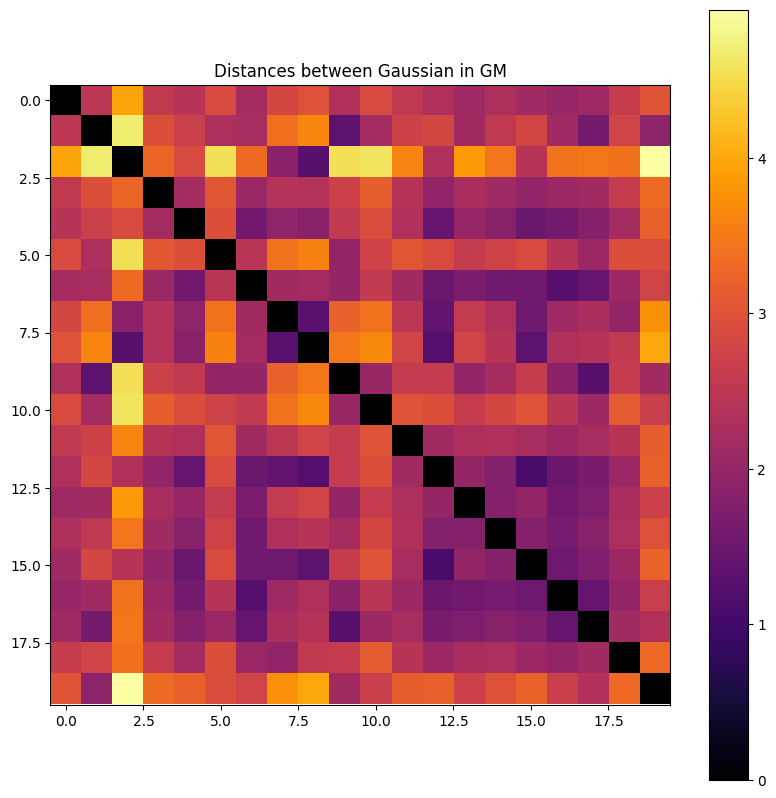

In [4]:
gm_dist = cdist(gmm.means_, gmm.means_)

plt.figure(figsize=(10,10))
plt.imshow(gm_dist, cmap="inferno")
plt.colorbar()
plt.title("Distances between Gaussian in GM")
plt.show()

In [ ]:
# Sample from GMM and generate sequences

sample = torch.tensor(gmm.sample(10_000)[0]).to(torch.float32)
gen_seq_onehot = AE_v1.reconstruction(sample).detach().numpy()
gen_seq = my_scripts.onehot2seq(gen_seq_onehot)
gen_req = [SeqRecord(Seq(gen_seq[i]), id="_", description="_") for i in range(len(gen_seq))]

SeqIO.write(gen_req, "Generated/gen.faa", "fasta")

10000

In [10]:
def compute_covariance(msa_onehot):
    return np.cov(msa_onehot, rowvar=False)  # Covariance across columns

def mask_diagonal_blocks(matrix, alphabet_size):
    L = matrix.shape[0]
    seq_length = L // alphabet_size  # Number of positions in the alignment
    mask = np.ones((L, L), dtype=bool)

    # Remove diagonal blocks (intra-position covariance)
    for i in range(seq_length):
        start = i * alphabet_size
        end = start + alphabet_size
        mask[start:end, start:end] = False  # Block out diagonal blocks

    return matrix[mask]  # Flattened non-diagonal block values

def pearson_between_covariances(msa1_onehot, msa2_onehot, alphabet_size=22):
    # Compute covariance matrices
    cov1 = compute_covariance(msa1_onehot)
    cov2 = compute_covariance(msa2_onehot)

    # Extract only off-diagonal blocks
    cov1_flat = mask_diagonal_blocks(cov1, alphabet_size)
    cov2_flat = mask_diagonal_blocks(cov2, alphabet_size)

    # Compute Pearson correlation
    pearson_corr, _ = pearsonr(cov1_flat, cov2_flat)
    
    return pearson_corr, cov1_flat, cov2_flat

In [ ]:
# Compute Pearson correlation between original and generated sequences

p1, p2 = [], []

for i in tqdm.tqdm(range(1, 50)) : 

    gmm = sklearn.mixture.GaussianMixture(n_components=i, random_state=SEED)
    gmm.fit(Xlatent)
    sample = torch.tensor(gmm.sample(10_000)[0]).to(torch.float32)
    gen_seq_onehot = AE_v1.reconstruction(sample).detach().numpy()

    x = np.mean(X, axis=0)
    y = np.mean(gen_seq_onehot, axis=0)
    p1.append(pearsonr(x, y))
    correlation, _, _ = pearson_between_covariances(X, gen_seq_onehot, 22)
    p2.append(correlation)

100%|██████████| 49/49 [41:37<00:00, 50.96s/it]


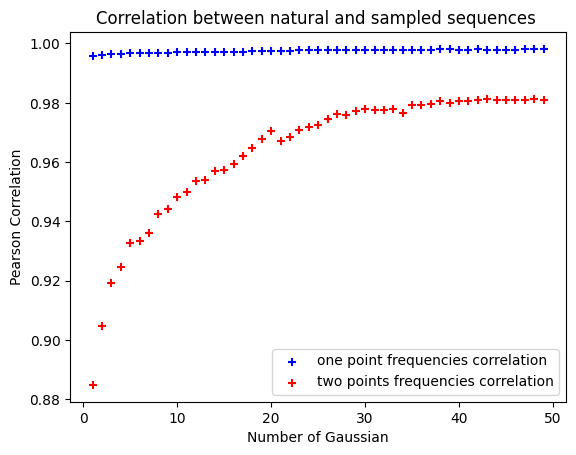

In [26]:
plt.scatter(np.arange(1, 50), np.array(p1)[:,0], c='b', label="one point frequencies correlation", marker="+")
plt.scatter(range(1, 50), p2, c='r', label="two points frequencies correlation", marker="+")
plt.legend()
plt.xlabel("Number of Gaussian")
plt.ylabel("Pearson Correlation")
plt.title("Correlation between natural and sampled sequences ")
plt.show()